# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [416]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X_col, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X_col, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [417]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



---

**Ответ**:

```
(method) def predict_proba(X: MatrixLike) -> (ndarray | list[ndarray])
Return probability estimates for the test vectors X.
```

---

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [418]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


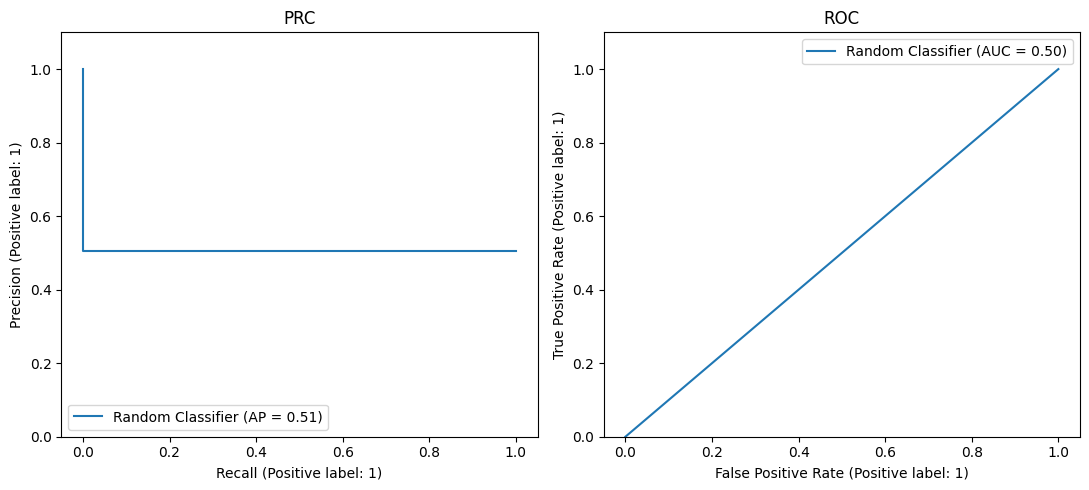

In [419]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(
      y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(
      y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [420]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [421]:
from sklearn.metrics import precision_recall_curve, auc, make_scorer, roc_auc_score


def pr_auc_score(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)


def update_metrics(metrics: pd.DataFrame, y_test, y_pred, name: str):
  # df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
  
  metrics.loc[name] = [
      pr_auc_score(y_test, y_pred),
      roc_auc_score(y_test, y_pred),
      0
  ]

In [422]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [423]:
# Support Vector Classification.
lsvc_model = SVC(kernel='linear', probability=True)
lsvc_params_grid_space = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
auc_pr_scorer = make_scorer(pr_auc_score, needs_proba=True)

lsvc_grid_search = GridSearchCV(
    lsvc_model, lsvc_params_grid_space, scoring=auc_pr_scorer, cv=5, verbose=10)
lsvc_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.0001....................................................


[CV 1/5; 1/6] END .....................C=0.0001;, score=0.828 total time=   4.7s
[CV 2/5; 1/6] START C=0.0001....................................................
[CV 2/5; 1/6] END .....................C=0.0001;, score=0.813 total time=   4.0s
[CV 3/5; 1/6] START C=0.0001....................................................
[CV 3/5; 1/6] END .....................C=0.0001;, score=0.845 total time=   3.9s
[CV 4/5; 1/6] START C=0.0001....................................................
[CV 4/5; 1/6] END .....................C=0.0001;, score=0.820 total time=   3.9s
[CV 5/5; 1/6] START C=0.0001....................................................
[CV 5/5; 1/6] END .....................C=0.0001;, score=0.832 total time=   4.0s
[CV 1/5; 2/6] START C=0.001.....................................................
[CV 1/5; 2/6] END ......................C=0.001;, score=0.814 total time=   3.0s
[CV 2/5; 2/6] START C=0.001.....................................................
[CV 2/5; 2/6] END ..........

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(pr_auc_score, needs_proba=True), verbose=10)

In [424]:
print("Best C:", lsvc_grid_search.best_params_['C'])

lsvc_best_model = lsvc_grid_search.best_estimator_
y_lsvc = lsvc_best_model.predict_proba(X_test)[:,1]

Best C: 0.0001


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVC metrics
AUC-PR: 0.83313
AUC-ROC: 0.83988


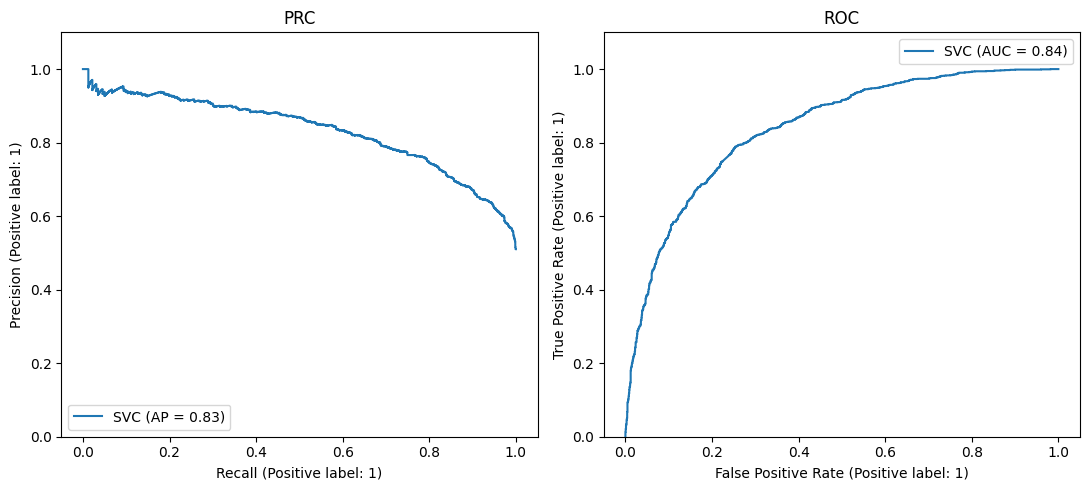

In [425]:
depict_pr_roc(y_test, y_lsvc, "SVC")

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [426]:
update_metrics(df_metrics, y_test, y_lsvc, "SVC")
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVC,0.833130,0.839879,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [427]:
from sklearn.linear_model import LogisticRegression

In [428]:
# Logistic Regression l2.
lr_model = LogisticRegression(penalty='l2')
lr_params_grid_space = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
auc_pr_scorer = make_scorer(pr_auc_score, needs_proba=True)

lr_grid_search = GridSearchCV(
    lr_model, lr_params_grid_space, scoring=auc_pr_scorer, cv=5, verbose=10)
lr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.0001....................................................
[CV 1/5; 1/6] END .....................C=0.0001;, score=0.825 total time=   0.0s
[CV 2/5; 1/6] START C=0.0001....................................................
[CV 2/5; 1/6] END .....................C=0.0001;, score=0.804 total time=   0.0s
[CV 3/5; 1/6] START C=0.0001....................................................
[CV 3/5; 1/6] END .....................C=0.0001;, score=0.843 total time=   0.0s
[CV 4/5; 1/6] START C=0.0001....................................................
[CV 4/5; 1/6] END .....................C=0.0001;, score=0.818 total time=   0.0s
[CV 5/5; 1/6] START C=0.0001....................................................
[CV 5/5; 1/6] END .....................C=0.0001;, score=0.830 total time=   0.0s
[CV 1/5; 2/6] START C=0.001.....................................................
[CV 1/5; 2/6] END ......................C=0.001;,

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(pr_auc_score, needs_proba=True), verbose=10)

In [429]:
print("Best C:", lr_grid_search.best_params_['C'])

lr_best_model = lr_grid_search.best_estimator_
lr_best_model.fit(X_train, y_train)
y_lr = lr_best_model.predict_proba(X_test)[:,1]

Best C: 0.001


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

LR metrics
AUC-PR: 0.83360
AUC-ROC: 0.84534


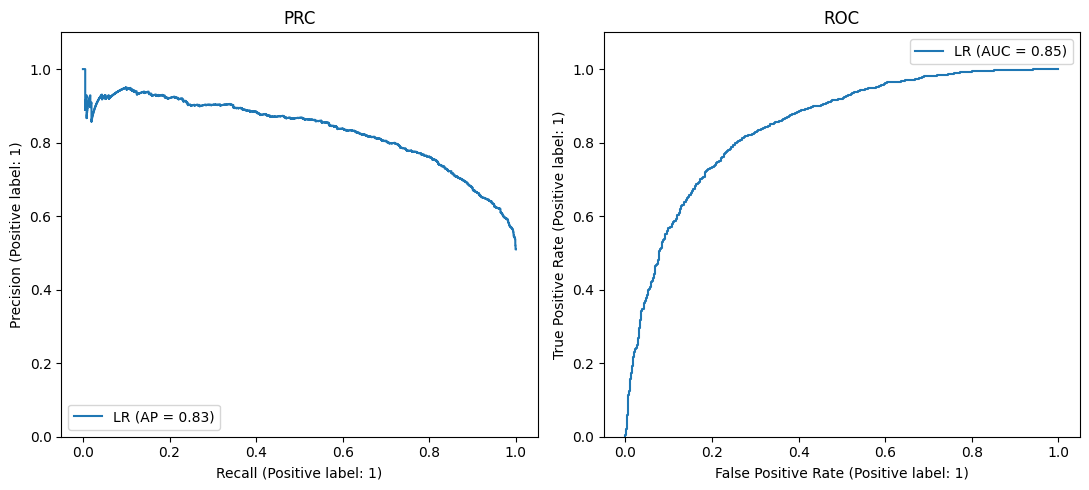

In [430]:
depict_pr_roc(y_test, y_lr, "LR")

In [431]:
update_metrics(df_metrics, y_test, y_lr, "LR")
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVC,0.833130,0.839879,0.0
LR,0.833599,0.845338,0.0


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



LR metrics
AUC-PR: 0.83360
AUC-ROC: 0.84534
LSVC metrics
AUC-PR: 0.83313
AUC-ROC: 0.83988


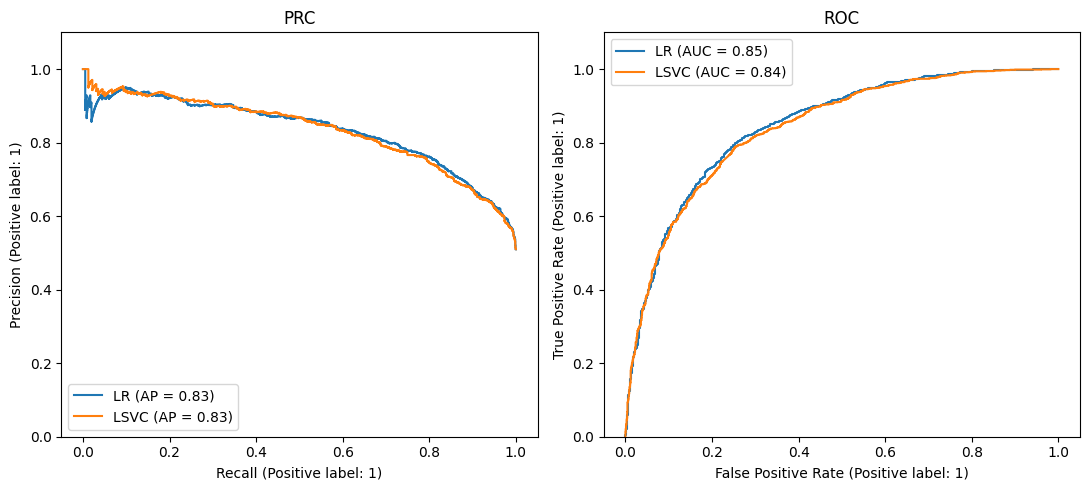

In [432]:
_, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_lr, "LR", ax)
depict_pr_roc(y_test, y_lsvc, "LSVC", ax)


---

**Ответ:** 
```
значения метрик AUC-PR и AUC-ROC близки друг к другу, и это говорит о том, что модели обладают схожей способностью разделять классы

По обеим метрикам можно сказать что LR лучше определяет предсказываемый класс
```

---

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [433]:
X_col, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X_col, y, test_size=0.3, random_state=42)

lsvc_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.0001....................................................


[CV 1/5; 1/6] END .....................C=0.0001;, score=0.933 total time=   3.4s
[CV 2/5; 1/6] START C=0.0001....................................................
[CV 2/5; 1/6] END .....................C=0.0001;, score=0.917 total time=   4.2s
[CV 3/5; 1/6] START C=0.0001....................................................
[CV 3/5; 1/6] END .....................C=0.0001;, score=0.935 total time=   3.4s
[CV 4/5; 1/6] START C=0.0001....................................................
[CV 4/5; 1/6] END .....................C=0.0001;, score=0.938 total time=   3.3s
[CV 5/5; 1/6] START C=0.0001....................................................
[CV 5/5; 1/6] END .....................C=0.0001;, score=0.933 total time=   3.2s
[CV 1/5; 2/6] START C=0.001.....................................................
[CV 1/5; 2/6] END ......................C=0.001;, score=0.937 total time=   1.9s
[CV 2/5; 2/6] START C=0.001.....................................................
[CV 2/5; 2/6] END ..........

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(pr_auc_score, needs_proba=True), verbose=10)

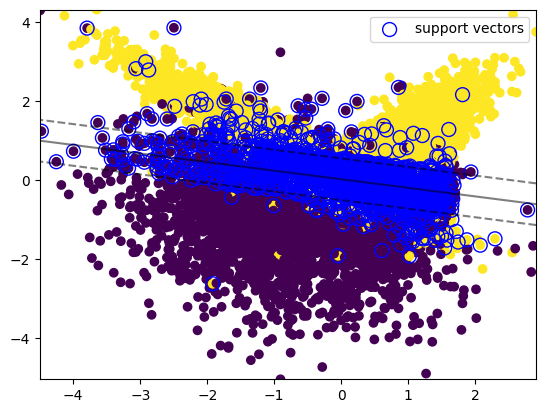

In [434]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k',
                levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()


plot_svm_2D(X_col, y, lsvc_grid_search.best_estimator_)

---

**Вопрос:** какие объекты выделяются как "опорные"?

**Ответ:** 

```Точки выборки данных, которые находятся ближе всего к гиперплоскости```

---

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [435]:
lr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.0001....................................................
[CV 1/5; 1/6] END .....................C=0.0001;, score=0.933 total time=   0.1s
[CV 2/5; 1/6] START C=0.0001....................................................
[CV 2/5; 1/6] END .....................C=0.0001;, score=0.917 total time=   0.1s
[CV 3/5; 1/6] START C=0.0001....................................................
[CV 3/5; 1/6] END .....................C=0.0001;, score=0.935 total time=   0.0s
[CV 4/5; 1/6] START C=0.0001....................................................
[CV 4/5; 1/6] END .....................C=0.0001;, score=0.937 total time=   0.0s
[CV 5/5; 1/6] START C=0.0001....................................................
[CV 5/5; 1/6] END .....................C=0.0001;, score=0.933 total time=   0.0s
[CV 1/5; 2/6] START C=0.001.....................................................
[CV 1/5; 2/6] END ......................C=0.001;,

[CV 2/5; 2/6] END ......................C=0.001;, score=0.924 total time=   0.0s
[CV 3/5; 2/6] START C=0.001.....................................................
[CV 3/5; 2/6] END ......................C=0.001;, score=0.941 total time=   0.0s
[CV 4/5; 2/6] START C=0.001.....................................................
[CV 4/5; 2/6] END ......................C=0.001;, score=0.943 total time=   0.0s
[CV 5/5; 2/6] START C=0.001.....................................................
[CV 5/5; 2/6] END ......................C=0.001;, score=0.939 total time=   0.0s
[CV 1/5; 3/6] START C=0.01......................................................
[CV 1/5; 3/6] END .......................C=0.01;, score=0.942 total time=   0.0s
[CV 2/5; 3/6] START C=0.01......................................................
[CV 2/5; 3/6] END .......................C=0.01;, score=0.933 total time=   0.0s
[CV 3/5; 3/6] START C=0.01......................................................
[CV 3/5; 3/6] END ..........

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(pr_auc_score, needs_proba=True), verbose=10)

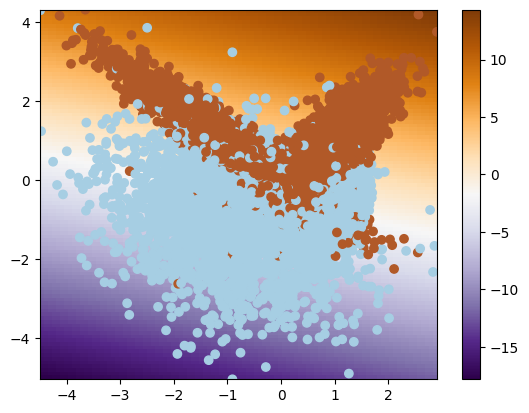

In [436]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy).reshape(XX.shape)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X_col, y, lr_grid_search.best_estimator_)

---

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?

**Ответ:** 

На графике область представлена как переходный цвет (белый).

Теоретическиое обоснование: логистическая функция, используемая в логистической регрессии для прогнозирования вероятности положительного исхода, имеет вид $sigmoid(z) = \frac{1}{1 + e^{-z}}$, где $z$ является линейной комбинацией входных признаков с весами, $z = w^Tx + b$. Когда $z = 0$, сигмоидная функция возвращает значение $0.5$, что интерпретируется как равная неопределенность между двумя классами. Геометрически плоскость, определенная как место, где $z = 0$, является границей решения модели, который разделяет точки данных на классы с вероятностью больше или меньше 0.5.

---

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [437]:
def plot_calibration_curve(y_test, preds, ax=None, label=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)  # :s/-/+/g
        bin_real_ratios.append(
            np.mean(y_test[(preds >= l) & (preds < r)] == 1))  # :s/min/mean/g
    # plt.figure(figsize=(6, 6))
    ax.plot(bin_middle_points, bin_real_ratios, label=label)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [438]:
X_col, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X_col, y, test_size=0.3, random_state=42)

In [439]:
lsvc_grid_search.fit(X_train, y_train)
lr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.0001....................................................


[CV 1/5; 1/6] END .....................C=0.0001;, score=0.828 total time=   4.2s
[CV 2/5; 1/6] START C=0.0001....................................................
[CV 2/5; 1/6] END .....................C=0.0001;, score=0.813 total time=   3.8s
[CV 3/5; 1/6] START C=0.0001....................................................
[CV 3/5; 1/6] END .....................C=0.0001;, score=0.845 total time=   3.8s
[CV 4/5; 1/6] START C=0.0001....................................................
[CV 4/5; 1/6] END .....................C=0.0001;, score=0.820 total time=   3.8s
[CV 5/5; 1/6] START C=0.0001....................................................
[CV 5/5; 1/6] END .....................C=0.0001;, score=0.832 total time=   3.8s
[CV 1/5; 2/6] START C=0.001.....................................................
[CV 1/5; 2/6] END ......................C=0.001;, score=0.814 total time=   3.1s
[CV 2/5; 2/6] START C=0.001.....................................................
[CV 2/5; 2/6] END ..........

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(pr_auc_score, needs_proba=True), verbose=10)

In [440]:
def scale(A):
    return (A - np.min(A)) / (np.max(A) - np.min(A))

Text(0.5, 1.0, 'Calibration curve')

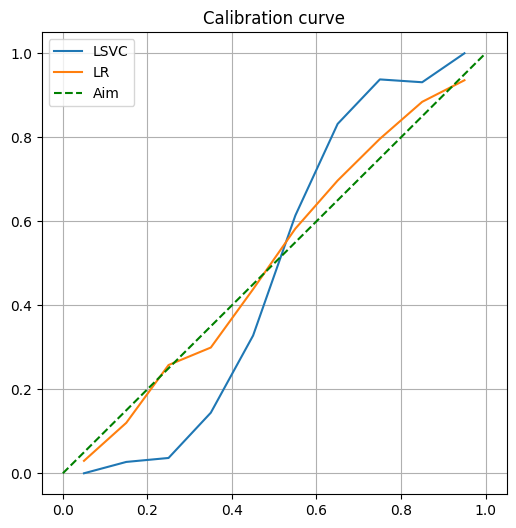

In [441]:
pred_lsvc = scale(lsvc_grid_search.decision_function(X_test))
pred_lr = lr_grid_search.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_calibration_curve(y_test, pred_lsvc, ax, 'LSVC')
plot_calibration_curve(y_test, pred_lr, ax, 'LR')
ax.plot([0, 1], [0, 1], label='Aim', linestyle='--', color='green')
ax.set_ylim([-0.05, 1.05])
ax.grid()
ax.legend()
ax.set_title('Calibration curve')

---

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** 

```
LR - достаточно хорошо откалибрована
SVM - очевидно хуже
```

---

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

Text(0.5, 0.98, 'Distribution')

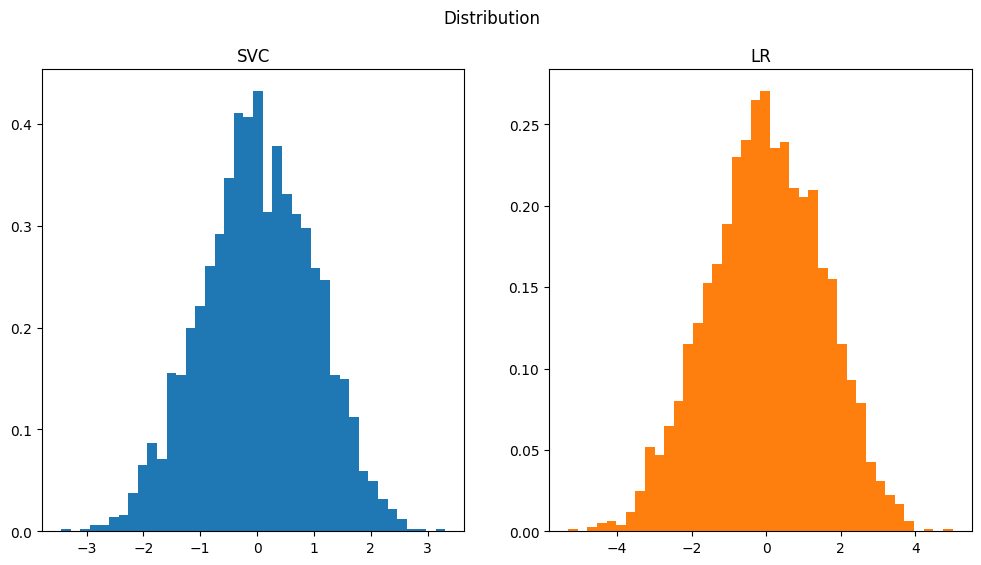

In [442]:
_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(lsvc_grid_search.decision_function(
    X_test), bins=40, color='C0', density='True')
ax[0].set_title('SVC')

ax[1].hist(lr_grid_search.decision_function(
    X_test), bins=40, color='C1', density='True')
ax[1].set_title('LR')

plt.suptitle('Distribution')

---

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** 

```
LR распределение чуть больше походит на нормальное. Скорее всего это можно объяснить то как LR (максимизация вероятности) и SVC (максимизация разделяющей плоскости) обучаются
```
---

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [443]:
from sklearn.calibration import CalibratedClassifierCV

lsvc_calibrated_model = CalibratedClassifierCV(
    base_estimator=lsvc_grid_search.best_estimator_, cv=5)
lsvc_calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=0.0001, kernel='linear',
                                          probability=True),
                       cv=5)

Text(0.5, 1.0, 'Calibration curve')

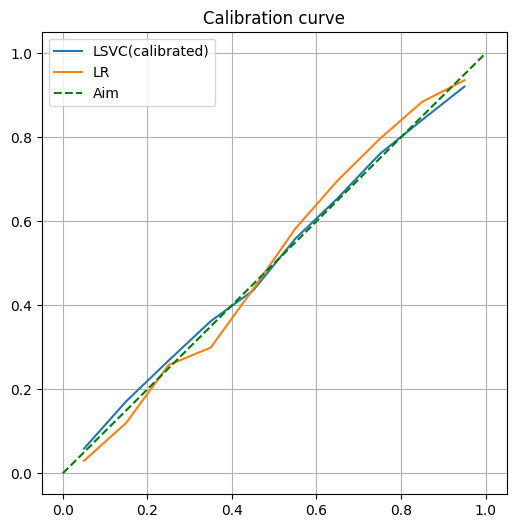

In [444]:
pred_lsvc_calibrated = lsvc_grid_search.predict_proba(X_test)[:, 1]
pred_lr = lr_grid_search.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_calibration_curve(y_test, pred_lsvc_calibrated, ax, 'LSVC(calibrated)')
plot_calibration_curve(y_test, pred_lr, ax, 'LR')
ax.plot([0, 1], [0, 1], label='Aim', linestyle='--', color='green')
ax.set_ylim([-0.05, 1.05])
ax.grid()
ax.legend()
ax.set_title('Calibration curve')

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** ```Калибровочная кривая для LSVC теперь выглядит лучше чем LR```

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

---

### Isotonic Regression

Метод изотонической регрессии заключается в нахождении монотонной функции, которая наилучшим образом аппроксимирует зависимость между наблюдаемыми данными. Изотоническая регрессия — это форма регрессии, в которой предполагается, что зависимая переменная является монотонно возрастающей или убывающей функцией независимой переменной.

Алгоритм: 

1. **Сортировка данных**: данные сортируются по возрастанию предсказанных вероятностей.

2. **Сегментация данных**: исходные данные делятся на сегменты, в пределах которых наблюдения считаются равными.

3. **Предсказание функции**: для каждого сегмента данных вычисляется среднее значение зависимой переменной. Это среднее значение используется для предсказания всех точек данных внутри сегмента.

4. **Оптимизация**: последовательно объединяются соседние сегменты и обновляется средняя зависимая переменная, пока функция монотонности не будет достигнута для всего диапазона данных.

В итоге изотоническая регрессия минимизирует сумму квадратов разностей между наблюдаемыми и предсказанными значениями для каждой точки данных, при этом сохраняя монотонность функции.

---

In [445]:
lsvc_isotonic_model = CalibratedClassifierCV(
    base_estimator=lsvc_grid_search.best_estimator_, cv=5, method='isotonic')
lsvc_isotonic_model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=0.0001, kernel='linear',
                                          probability=True),
                       cv=5, method='isotonic')

Text(0.5, 1.0, 'Calibration curve')

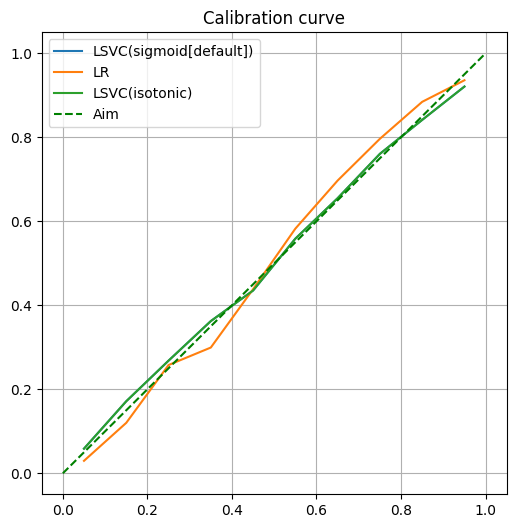

In [446]:
pred_lsvc_isotonic = lsvc_isotonic_model.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_calibration_curve(y_test, pred_lsvc_calibrated, ax, 'LSVC(sigmoid[default])')
plot_calibration_curve(y_test, pred_lr, ax, 'LR')
plot_calibration_curve(y_test, pred_lsvc_calibrated, ax, 'LSVC(isotonic)')
ax.plot([0, 1], [0, 1], label='Aim', linestyle='--', color='green')
ax.set_ylim([-0.05, 1.05])
ax.grid()
ax.legend()
ax.set_title('Calibration curve')

---

```
Калибровка с помощью Isotonic Regression дала такой же результат как и дефолтный метод (sigmoid)
```

---

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [577]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
display(df.isna().any())


categorical = []
numeric = []
other = []

for c in df.columns:
    if df[c].dtype in [np.int64, np.float64]:
        numeric += [c]
    elif df[c].dtype == np.object_:
        categorical += [c]
    else:
        other += [c]

print('Numeric features:', numeric)
print('\nCategorical features:', categorical)
print('\nOther features:', other)

df[categorical] = df[categorical].fillna('undefined')

display(df.isna().any())


ID                  False
Marital Status       True
Gender               True
Income               True
Children             True
Education           False
Occupation          False
Home Owner           True
Cars                 True
Commute Distance    False
Region              False
Age                  True
Purchased Bike      False
dtype: bool

Numeric features: ['ID', 'Income', 'Children', 'Cars', 'Age']

Categorical features: ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Purchased Bike']

Other features: []


ID                  False
Marital Status      False
Gender              False
Income               True
Children             True
Education           False
Occupation          False
Home Owner          False
Cars                 True
Commute Distance    False
Region              False
Age                  True
Purchased Bike      False
dtype: bool

In [578]:

X_col = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

categorical.remove('Purchased Bike')
#Разделим на категориальные признаки и числовые
X_numeric = X_col[numeric]
X_categorical = X_col[categorical]

В начале поработаем только с категориальными признаками

In [579]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [580]:
# utils

import time


class Timer:
    def __init__(self):
        self.t = []
        self.a = 0

    def start(self):
        self.a = time.time()

    def stop(self):
        if self.a != 0:
            self.t += [time.time() - self.a]
        self.a = 0

    def restart(self):
        self.stop()
        self.start()

    def get_mean(self):
        return sum(self.t) / len(self.t)

    def get_last(self):
        return self.t[-1]

timer = Timer()
df_metrics_2 = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'time'])

def update_metrics_2(metrics, y_test, y_pred, time, name: str):
  # def_metrics_2 = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'time'])
  metrics.loc[name] = [
      pr_auc_score(y_test, y_pred),
      roc_auc_score(y_test, y_pred),
      time
  ]

In [581]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [582]:
default_col_tr = ColumnTransformer(
    [('oe', OrdinalEncoder(), categorical)])

pipeline = Pipeline(steps=[
    ('ct', default_col_tr),
    ('regression', LogisticRegression(max_iter=100000))
])
timer.start()
model = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_2(df_metrics_2, y_test,
                 model.predict_proba(X_test)[:, 1], timer.get_last(), 'OE')
display(df_metrics_2)

,AUC_PR,AUC_ROC,time
OE,0.578944,0.592404,0.035706


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [583]:
default_col_tr = ColumnTransformer(
    [('oe', OneHotEncoder(), categorical)])

pipeline = Pipeline(steps=[
    ('ct', default_col_tr),
    ('regression', LogisticRegression(max_iter=100000))
])
timer.start()
model = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_2(df_metrics_2, y_test, 
                 model.predict_proba(X_test)[:, 1], timer.get_last(), 'OHE')
display(df_metrics_2)

,AUC_PR,AUC_ROC,time
OE,0.578944,0.592404,0.035706
OHE,0.661865,0.680032,0.031860


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [584]:
from importlib import reload
import mean_target_encoder as mte
reload(mte)


pipeline = Pipeline(steps=[
    ('mte', mte.MeanTargetEncoder(columns=categorical)),
    ('regression', LogisticRegression(max_iter=100000))
])


timer.start()
model = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_2(df_metrics_2, y_test, 
                 model.predict_proba(X_test)[:, 1], timer.get_last(), 'MTE')
display(df_metrics_2)

,AUC_PR,AUC_ROC,time
OE,0.578944,0.592404,0.035706
OHE,0.661865,0.680032,0.031860
MTE,0.652694,0.664712,0.062739


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [585]:
# см. mean_target_encoder.py

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [586]:
from importlib import reload
import mean_target_encoder as mte
reload(mte)


pipeline = Pipeline(steps=[
    ('mte', mte.MeanTargetEncoder(columns=categorical, noise=True)),
    ('regression', LogisticRegression(max_iter=100000))
])


timer.start()
model = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_2(df_metrics_2, y_test,
                 model.predict_proba(X_test)[:, 1], timer.get_last(), 'MTE_noise')
display(df_metrics_2)

,AUC_PR,AUC_ROC,time
OE,0.578944,0.592404,0.035706
OHE,0.661865,0.680032,0.031860
MTE,0.652694,0.664712,0.062739
MTE_noise,0.663374,0.667628,0.058720


---

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** 

```
В целом добавление шума помогло, но от запуска к запуску (так как внутри рандом) метрика(pr-auc) может быть чуть хуже, а может быть и чуть лучше чем без шума. Однако время почти всегда чуть лучше, так как наша фича превратилась в более-менее случайную величину.
```

---

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




---

```
Попытка реализовать 1 способ, дедлайн упал на голову, не успел отдебажить((((((
```
---

In [592]:
from importlib import reload
import mean_target_encoder as mte
reload(mte)


pipeline = Pipeline(steps=[
    ('mte', mte.MeanCumsumTargetEncoder(columns=categorical, noise=True)),
    ('regression', LogisticRegression(max_iter=100000))
])


timer.start()
model = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_2(df_metrics_2, y_test,
                 model.predict_proba(X_test)[:, 1], timer.get_last(), 'MTE_cumsum_noise')
display(df_metrics_2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
1/0

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
from importlib import reload
import mean_target_encoder as mte
reload(mte)


pipeline = Pipeline(steps=[
    ('mte', mte.MeanTargetSmoothedEncoder(columns=categorical, C=6)), # C подобрано эмпирически
    ('regression', LogisticRegression(max_iter=100000))
])


timer.start()
model = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_2(df_metrics_2, y_test, model.predict_proba(
    X_test)[:, 1], timer.get_last(), 'MTE_smoothed')
display(df_metrics_2)

,AUC_PR,AUC_ROC,time
OE,0.578944,0.592404,0.014089
OHE,0.661865,0.680032,0.029337
MTE,0.652694,0.664712,0.060050
MTE_noise,0.652561,0.654551,0.056157
MTE_smoothed,0.670817,0.664776,0.055861


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
numeric.remove('ID')
df[numeric] = df[numeric].fillna(df.mean())
display(df.isna().any())

ID                  False
Marital Status      False
Gender              False
Income              False
Children            False
Education           False
Occupation          False
Home Owner          False
Cars                False
Commute Distance    False
Region              False
Age                 False
Purchased Bike      False
dtype: bool

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [ ]:
print('Unique numeric values count:')
unique_cnt_stats = pd.DataFrame(columns=['count', 'values'])
for c in numeric:
  unique_cnt_stats.loc[c] =[len(df[c].unique()), df[c].unique()] 

display(unique_cnt_stats)

Unique numeric values count:


,count,values
Income,17,"[40000.0, 30000.0, 80000.0, 70000.0, 10000.0, ..."
Children,7,"[1.0, 3.0, 5.0, 0.0, 2.0, 4.0, 1.9102822580645..."
Cars,6,"[0.0, 1.0, 2.0, 4.0, 1.455095862764884, 3.0]"
Age,54,"[42.0, 43.0, 60.0, 41.0, 36.0, 50.0, 33.0, 58...."


In [ ]:
X_col = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X_col, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
from importlib import reload
import mean_target_encoder as mte
reload(mte)

df_metrics_comb = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'time'])

def run_mte(numeric, categorical, stat_name):
    steps = []
    if len(categorical) > 0:
        steps += [('mte', mte.MeanTargetEncoder(columns=categorical))]
    if len(numeric) > 0:
        steps += [('ct', ColumnTransformer([('scaling', StandardScaler(), numeric)]))]
    steps += [('regression', LogisticRegression(max_iter=100000))]

    pipeline = Pipeline(steps=steps)

    timer.start()
    model = pipeline.fit(X_train, y_train)
    timer.stop()

    update_metrics_2(df_metrics_comb, y_test, model.predict_proba(
        X_test)[:, 1], timer.get_last(), stat_name)


run_mte(numeric, categorical, f'MTE(None)')
numeric_set = set(numeric)
categorical_set = set(categorical)
for feat in numeric_set:
    new_numeric = numeric_set ^ set([feat])
    new_categorical = categorical_set | set([feat])
    run_mte(list(new_numeric), list(new_categorical), f'MTE({feat})')
run_mte([], numeric+categorical, f'MTE(All)')

display(df_metrics_comb)

,AUC_PR,AUC_ROC,time
MTE(None),0.623853,0.696571,0.052955
MTE(Cars),0.531560,0.590641,0.059640
MTE(Children),0.638360,0.705769,0.067222
MTE(Income),0.623840,0.634872,0.077742
MTE(Age),0.628272,0.701122,0.135514
MTE(All),0.470470,0.470256,0.155830


```
Как можно заметить разные комбинации дают разные результаты, какой-то закономерности с кол-во уникальных значений не наблюдается, но все фичи воспринимать как категориальные и кодировать их через MTE -- не самая хорошая идея
```

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

In [ ]:
display(df_metrics_2)

,AUC_PR,AUC_ROC,time
OE,0.578944,0.592404,0.014089
OHE,0.661865,0.680032,0.029337
MTE,0.652694,0.664712,0.060050
MTE_noise,0.652561,0.654551,0.056157
MTE_smoothed,0.670817,0.664776,0.055861


---

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

```
* OHE нужно меньше времени для кодирования (так как алгоритм достаточно простой)
* MTE же тратит меньше памяти и не увеличивает кол-во признаков, из минусов - существует вероятность переобучения.
* По качеству классический MTE немного уступает OHE, но если подшаманить, то можно получить достойное улучшение по сравнению с OHE
```

---

In [ ]:
1/0

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

categorical = [
    'education',
    'marital-status',
    'native-country',
    'occupation',
    'race',
    'relationship',
    'sex',
    'workclass',
]

numeric = [
    'age',
    'capital-gain',
    'capital-loss',
    'education-num',
    'fnlwgt',
    'hours-per-week',
]


df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27595,59,?,145574,Assoc-acdm,12,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
X_col = df.drop(['income'], axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X_col, y, test_size=0.25, random_state=777, stratify = y)

In [ ]:

df_metrics_3 = pd.DataFrame(
    columns=['AUC_PR', 'AUC_ROC', 'time'])
def update_metrics_3(y_test, y_pred, time, name: str):
  # df_metrics_3 = pd.DataFrame(columns=['AUC_PR', 'time'])
  df_metrics_3.loc[name] = [
      pr_auc_score(y_test, y_pred),
      roc_auc_score(y_test, y_pred),
      time
  ]

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
original_count = X_train.shape[1]
ohe_count = OneHotEncoder(handle_unknown="ignore").fit_transform(X_train[categorical], y_train).shape[1]

print(f'Not encoded features count: {original_count}')
print(f'OH  encoded features count: {ohe_count} (+{ohe_count-original_count})')

Not encoded features count: 14
OH  encoded features count: 102 (+88)


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
default_col_tr = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('default_ct', default_col_tr),
    ('reg', LogisticRegression(max_iter=100000))
])

timer.start()
model_1 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_1.predict_proba(X_test)[:,1],
                 timer.get_last(), 'original')
display(df_metrics_3)

,AUC_PR,AUC_ROC,time
original,0.76713,0.906985,0.704727


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
from importlib import reload
import top_select_transformer as tst
reload(tst)

pipeline = Pipeline(steps=[
    ('default_ct', default_col_tr),
    ('twst', tst.TSTransformer(40, model_1['reg'].coef_[0])),
    ('reg', LogisticRegression(max_iter=100000))
])


timer.start()
model_2 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_2.predict_proba(X_test)[:,1],
                 timer.get_last(), 'TWS')
display(df_metrics_3)

LOG_DEBUG: top ids [ 84  61  66  10  97  14  68 104  86  64  98  81  37 102 107  59  62  92
  77  32  28  47  53  75   3   4  94  78 105  45  76  33  34  24  25  69
  90  18  17 103]


,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363


Изменилось ли качество? Как?

```
Качество немного ухудшилось, но улучшилось время
```

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

In [ ]:
pipeline = Pipeline(steps=[
    ('ct', ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
    ])),
    ('reg', LogisticRegression(max_iter=100000))
])

timer.start()
model_3 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_3.predict_proba(X_test)[:,1],
                 timer.get_last(), 'original(no scaling)')
display(df_metrics_3)

,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363
original(no scaling),0.686027,0.881437,0.428107


In [ ]:
from importlib import reload
import top_select_transformer as tst
reload(tst)


pipeline = Pipeline(steps=[
    ('default_ct', default_col_tr),
    ('twst', tst.TSTransformer(40, model_3['reg'].coef_[0])),
    ('regression', LogisticRegression(max_iter=100000))
])

timer.start()
model_4 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_4.predict_proba(X_test)[:,1],
                 timer.get_last(), 'TWS(no scaling)')
display(df_metrics_3)

LOG_DEBUG: top ids [15 82 37 89 97 66 44 68 61 84 81  8  7 64 86 62 92 77 28 47 98 32 53 78
 75 94 76 34 45 33  9 25 24 69 90 17 18 12 14 10]


,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363
original(no scaling),0.686027,0.881437,0.428107
TWS(no scaling),0.681736,0.876365,0.299888


Что получилось?

```
Как видим, без мастабирования результат ухудшился еще сильнее

Также можем заметить, что набор самых весомых фичей также отличается от варианта с масштабированием
```

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
pipeline = Pipeline(steps=[
    ('ct', ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ])),
    ('scaling', StandardScaler(with_mean=False)),
    ('reg', LogisticRegression(max_iter=100000))
])

timer.start()
model_5 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_5.predict_proba(X_test)[:,1],
                 timer.get_last(), 'original(scale all)')
display(df_metrics_3)

,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363
original(no scaling),0.686027,0.881437,0.428107
TWS(no scaling),0.681736,0.876365,0.299888
original(scale all),0.684410,0.881256,0.675404


In [ ]:
from importlib import reload
import top_select_transformer as tst
reload(tst)

pipeline = Pipeline(steps=[
    ('default_ct', default_col_tr),
    ('twst', tst.TSTransformer(40, model_5['reg'].coef_[0])),
    ('regression', LogisticRegression(max_iter=100000))
])

timer.start()
model_6 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_6.predict_proba(X_test)[:,1],
                 timer.get_last(), 'TWS(scale all)')
display(df_metrics_3)

LOG_DEBUG: top ids [60 59 41 37 44 61 68 64 84 47 81 28 32  7  8 24 97 33 53 45 34 25 17 62
 89 78 76 98 94 77 75 86 92 90 10 14  9 69 12 18]


,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363
original(no scaling),0.686027,0.881437,0.428107
TWS(no scaling),0.681736,0.876365,0.299888
original(scale all),0.684410,0.881256,0.675404
TWS(scale all),0.676419,0.873007,0.329990


Изменился ли их список? Изменится ли качество?


```

Num scaled:   [84  61  66  10  97  14  68 104  86  64  98  81  37 102 107  59  62  92 ...]
None scaled:  [15  82  37  89  97  66  44  68  61  84  81   8   7  64  86  62  92  77 ...]
All scaled:   [60  59  41  37  44  61  68  64  84  47  81  28  32   7   8  24  97  33 ...]

Список ожидаемо изменился? Качество просело еще больше
```

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
def t_filter(X, target):
  res = []  # coefficients in columns order
  for column in range(X.shape[1]):
    X_col = X[:, column].copy().A

    def mu(c): return X_col[target == c].mean()
    def sigma(c): return np.std(X_col[target == c])
    def n(c): return X_col[target == c].shape[0]

    t = (
        abs(mu(1) - mu(0)) /
        np.sqrt(
            (n(1)*sigma(1) ** 2 + n(0)*sigma(0)**2) /
            (n(1) + n(0))
        )
    )
    res.append(t)
  return np.array(res)

In [ ]:

from importlib import reload
import top_select_transformer as tst
reload(tst)

filter = t_filter(default_col_tr.fit_transform(X_train), y_train)
pipeline = Pipeline(steps=[
    ('default_ct', default_col_tr),
    ('twst', tst.TSTransformer(40, filter)),
    ('regression', LogisticRegression(max_iter=100000))
])

timer.start()
model_8 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_8.predict_proba(X_test)[:,1],
                 timer.get_last(), 'TWS(f-filter)')
display(df_metrics_3)


LOG_DEBUG: top ids [ 22  94  49  72  15   0  93  65  21  97  87  71  84   1  66  82  90  11
  16  98  10  89 104  73  14   9  12  75  86  69  91  92 103 107  88 102
  20 105  85  18]


,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363
original(no scaling),0.686027,0.881437,0.428107
TWS(no scaling),0.681736,0.876365,0.299888
original(scale all),0.684410,0.881256,0.675404
TWS(scale all),0.676419,0.873007,0.329990
TWS(f-filter),0.761986,0.904266,0.416600


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

X_train_tr = default_col_tr.fit_transform(X_train)
model_log_reg = LogisticRegression(max_iter=10000)

timer.start()
selector = SequentialFeatureSelector(model_log_reg,
                                    n_features_to_select=40,
                                    direction='backward',
                                    scoring=make_scorer(
                                        average_precision_score),
                                    cv=2)
selector.fit(X_train_tr, y_train)
timer.stop()

print('Time:', timer.get_last())

Time: 1935.4132602214813


In [ ]:
def get_selected_features_ids(selector):
  return np.array([i for i in range(len(selector.support_)) if selector.support_[i]])

selected_features = get_selected_features_ids(selector)
print('selected features ids:', selected_features)

selected features ids: [  5   7  10  14  18  20  23  34  45  62  66  68  69  70  71  72  73  76
  77  79  80  81  82  83  85  87  88  89  90  93  94  97  98  99 102 103
 104 105 106 107]


In [ ]:
from importlib import reload
import top_select_transformer as tst
reload(tst)

pipeline = Pipeline(steps=[
    ('default_ct', default_col_tr),
    ('twst', tst.DummySelector(selected_features)),
    ('regression', LogisticRegression(max_iter=100000))
])

timer.start()
model_10 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_10.predict_proba(X_test)[:,1],
                 timer.get_last(), 'SFS(backward)')
display(df_metrics_3)

LOG_DEBUG: dummy ids [  5   7  10  14  18  20  23  34  45  62  66  68  69  70  71  72  73  76
  77  79  80  81  82  83  85  87  88  89  90  93  94  97  98  99 102 103
 104 105 106 107]


,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363
original(no scaling),0.686027,0.881437,0.428107
TWS(no scaling),0.681736,0.876365,0.299888
original(scale all),0.684410,0.881256,0.675404
TWS(scale all),0.676419,0.873007,0.329990
TWS(f-filter),0.761986,0.904266,0.416600
SFS(backward),0.767228,0.905801,0.289821


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
timer.start()
selector_fwd = SequentialFeatureSelector(model_log_reg,
                                         n_features_to_select=40,
                                         direction='forward',
                                         scoring=make_scorer(
                                             average_precision_score),
                                         cv=2)
selector_fwd.fit(X_train_tr, y_train)
timer.stop()

print('Time forward:', timer.get_last())

Time forward: 465.05194091796875


In [ ]:

selected_fwd_features = get_selected_features_ids(selector_fwd)
print('selected features ids:', selected_fwd_features)

selected features ids: [  3   4  10  13  14  17  19  21  24  25  28  29  30  32  34  36  37  38
  39  40  42  43  46  47  48  51  53  54  55  57  60  63  64  68  71  74
  96 101 103 104]


In [ ]:
pipeline = Pipeline(steps=[
    ('default_ct', default_col_tr),
    ('twst', tst.DummySelector(selected_fwd_features)),
    ('regression', LogisticRegression(max_iter=100000))
])

timer.start()
model_11 = pipeline.fit(X_train, y_train)
timer.stop()

update_metrics_3(y_test, model_11.predict_proba(X_test)[:, 1],
                 timer.get_last(), 'SFS(forward)')
display(df_metrics_3)

LOG_DEBUG: dummy ids [  3   4  10  13  14  17  19  21  24  25  28  29  30  32  34  36  37  38
  39  40  42  43  46  47  48  51  53  54  55  57  60  63  64  68  71  74
  96 101 103 104]


,AUC_PR,AUC_ROC,time
original,0.767130,0.906985,0.704727
TWS,0.764018,0.905327,0.444363
original(no scaling),0.686027,0.881437,0.428107
TWS(no scaling),0.681736,0.876365,0.299888
original(scale all),0.684410,0.881256,0.675404
TWS(scale all),0.676419,0.873007,0.329990
TWS(f-filter),0.761986,0.904266,0.416600
SFS(backward),0.767228,0.905801,0.289821
SFS(forward),0.544622,0.677957,0.333365


---

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

```
backward-отбор (отбрасывание) считал очень долго, но справился со свой задачей и улучшил качество модели на целую тысячную по auc-pr
forward-отбор (добавление) - почетный лузер сегодняшнего соревнования...


Подводя итог, на наших данных разные методы дали схожие результаты. Если нужно максимальное качество выбираем backward-отбор, но запасаемся стойкой Nvidia v100 и считаем. Если деняк нет то и можно подождать пол года, ну или просто воспользоваться top weight отбором.
```

---

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-26 23:00:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [     <=>            ] 434,15K   432KB/s    in 1,0s    

2023-11-26 23:00:19 (432 KB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X_col = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
# your code here

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here